In [45]:
import BondGraphTools as bgt
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import matplotlib.colors
from pylab import rcParams
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import copy
import difflib
import os

In [2]:
FMA = pandas.read_csv('FMA.csv')
CHEBI = pandas.read_csv('CHEBI.csv')
OPB = pandas.read_csv('OPB.csv')

fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def catRecognition():
    
    print('Please select the category of the reaction according to the following list:')
    
    print('\n')
    print('SERCA activation ==> insert "s"')
    print('tricalcium bis(phosphate) production ==> insert "t"')

    print('\n')
    
    
    category=[]
    address=[]
    
    def askForMore(cat,add):
        
        c=input('Enter the category of the reaction : ')
        c=difflib.get_close_matches(c, ['s', 't'])
        cat.append(c)
        
        add.append(input('Enter the location address for the corresponding file : '))
        
        more=input('More reactions?(Y/N)')
     
        if more.lower() == 'y':
            [cat,add] = askForMore(cat,add)

        elif more.lower() != 'y':
            return [cat,add]        

    askForMore(category,address)

    return [category,address]

/Users/nsha457/Documents/Jupyter_files/New folder/Diffusion_vars.cellml

/Users/nsha457/Documents/Jupyter_files/New folder/Reaction.cellml

In [4]:
# Here, the category of each reaction is asked along with the file location. Enter the location of the cellml file 
# similar to the ones above (Markdown Cell)
[categories,addresses]=catRecognition()

Please select the category of the reaction according to the following list:


SERCA activation ==> insert "s"
tricalcium bis(phosphate) production ==> insert "t"


Enter the category of the reaction : s
Enter the location address for the corresponding file : /Users/nsha457/Documents/Jupyter_files/New folder/Diffusion_vars.cellml
More reactions?(Y/N)y
Enter the category of the reaction : t
Enter the location address for the corresponding file : /Users/nsha457/Documents/Jupyter_files/New folder/Reaction.cellml
More reactions?(Y/N)n


In [5]:
def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    base=os.path.basename(add)
    f = open(base,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)
        
    # In this part we match the number found in the rdf of the CellML file 
    # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'thermodynamic constant' in l.lower():
                annotations1[i].append('thermodynamic constant')


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 
        
    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1
        
    return [List,annotations,root]

In [6]:
def CM_whole(*connectivityMatrices):
    cm=list(connectivityMatrices)
    
    # Creating a dictionary with empty lists for adding the connectivity matrices for each sub-system
    CM={}
    for n in range(len(cm)):
        CM[str(n)]=copy.deepcopy(cm[n])
    
    Length=0
    for n in range(len(cm)):
        Length+=len(CM[str(n)])
    connectivity_matrix_0=np.zeros((Length,Length))  
    
    k=0
    for n in range(len(cm)):
        for i in range(k,k+len(CM[str(n)])):
            for j in range(k,k+len(CM[str(n)])):
                connectivity_matrix_0[i][j]=copy.deepcopy(CM[str(n)][i-k][j-k])
        k+=len(CM[str(n)])
    return connectivity_matrix_0

In [7]:
def CBR_Gen(*compsList):
    CBR=[];
    for i in range(len(compsList)):
        for j in range(len(compsList[i])):
            CBR.append(compsList[i][j])
            
    return CBR

In [8]:
def BondsConnection(connectivity_matrix,CBR):
    

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivity_matrix)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivity_matrix[i][j]==1:
                bonds.append((CBR[i],CBR[j]))



    
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [9]:
def valExtraction(annotations,root,List): # Extracting values from the cellml file
    
    keytoAmounts=[]; varID=[]; variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   ################ Here search for the listID elements in the variables and initials
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [10]:
def diffModelMaker(Model,annotations,List,els,init):
    Diff_Dict={0: ['temperature'],1: ['ideal gas constant'], 2: ['serca activator','reaction rate constant'], # Kappa
                  3: ['extracellular space','calcium cation','concentration of chemical'],  # q_A (Ca2+ extra)
                  4: ['cytosol of cardiac myocyte','calcium cation','concentration of chemical'], # q_B (Ca2+ cytosol)
                  5: ['extracellular space','calcium cation','concentration of chemical', 'thermodynamic constant'], # K_A
                  6: ['cytosol of cardiac myocyte','calcium cation','concentration of chemical', 'thermodynamic constant']}

    # BG model
    A = bgt.new("Ce", name=Diff_Dict[3], library="BioChem")
    B = bgt.new("Ce", name=Diff_Dict[4], library="BioChem")
    zeroJunctionA = bgt.new("0", name=Diff_Dict[3])
    zeroJunctionB = bgt.new("0", name=Diff_Dict[4])
    oneJunctionA = bgt.new("1", name=Diff_Dict[3])
    oneJunctionB = bgt.new("1", name=Diff_Dict[4])
    reaction = bgt.new("Re",name=Diff_Dict[2], library="BioChem")
    
    Components={0:A, 1:B, 2:reaction, 3:zeroJunctionA, 4:zeroJunctionB, 5:oneJunctionA, 6:oneJunctionB} 
    mergeableComponents=[A, B, zeroJunctionA, zeroJunctionB]

    # Adding the components to the model
    
    for k,v in Components.items():
        bgt.add(Model,v)
    
    connectivityMatrix=np.zeros((7,7))
    connectivityMatrix[0][2]=1; connectivityMatrix[2][4]=1; connectivityMatrix[3][1]=1; connectivityMatrix[4][6]=1;
    connectivityMatrix[5][3]=1; connectivityMatrix[6][5]=1;
    
    cm=[]
    for i in range(len(connectivityMatrix)):
        cm.append(list(connectivityMatrix[i]))

    connectivityBondsRow=[A, B,zeroJunctionA, zeroJunctionB, oneJunctionA, oneJunctionB, reaction]
    

    stateVarsInitials={}   
        
    for a in range(len(annotations)):
        if set(annotations[a]) == set(Diff_Dict[0]):  #T
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if parameter_name is ("T"):
                            bgt.set_param(Model, param_index, float(init[e]))
                            

        elif set(annotations[a]) == set(Diff_Dict[1]): #R
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if parameter_name is ("R"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(Diff_Dict[2]): # SERCA reaction rate
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is Diff_Dict[2] and parameter_name is ("r"):
                            bgt.set_param(Model, param_index, float(init[e]))


        elif set(annotations[a]) == set(Diff_Dict[5]): #K_A
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is Diff_Dict[3] and parameter_name is ("k"):
                            bgt.set_param(Model, param_index, float(init[e]))


        elif set(annotations[a]) == set(Diff_Dict[6]): #K_B
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is Diff_Dict[4] and parameter_name is ("k"):
                            bgt.set_param(Model, param_index, float(init[e]))


        elif set(annotations[a]) == set(Diff_Dict[3]): #q_A
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    stateVarsInitials[str(set(Diff_Dict[3]))] = (float(init[e]))

        elif set(annotations[a]) == set(Diff_Dict[4]):  #q_B
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    stateVarsInitials[str(set(Diff_Dict[4]))] = (float(init[e]))



    
    return[stateVarsInitials,cm,connectivityBondsRow,mergeableComponents,Components]
     

In [11]:
def reactModelMaker( Model,annotations,List,els,init):

    React_Dict={0: ['temperature'],
     1: ['ideal gas constant'], 
     2: ['tricalcium bis(phosphate)','reaction rate constant'],
     3: ['cytosol of cardiac myocyte','calcium cation','concentration of chemical'], # q_B (Ca2+)
     4: ['cytosol of cardiac myocyte','phosphate ion','concentration of chemical'], # q_A (PO4(3-))
     5: ['cytosol of cardiac myocyte','tricalcium bis(phosphate)','concentration of chemical'], # q_C (Ca3PO4(2))
     6: ['cytosol of cardiac myocyte','calcium cation','concentration of chemical', 'thermodynamic constant'], # K_B (Ca2+) 
     7: ['cytosol of cardiac myocyte','phosphate ion','concentration of chemical', 'thermodynamic constant'], # K_A (PO4(3-)) 
     8: ['cytosol of cardiac myocyte','tricalcium bis(phosphate)','concentration of chemical','thermodynamic constant'], # K_C (Ca3PO4(2))
     9: ['cytosol of cardiac myocyte', 'calcium cation','molar amount of chemical'], #stoi_B (Ca2+)
     10: ['cytosol of cardiac myocyte', 'phosphate ion','molar amount of chemical'],  #stoi_A (PO4(3-))
     11: ['cytosol of cardiac myocyte', 'tricalcium bis(phosphate)','molar amount of chemical'] #stoi_C (Ca3PO4(2))
           }

    # BG model of a model of 3 species
    A = bgt.new("Ce", name=React_Dict[4], library="BioChem")
    B = bgt.new("Ce", name=React_Dict[3], library="BioChem")
    C = bgt.new("Ce", name=React_Dict[5], library="BioChem")

    reaction = bgt.new("Re" , name=React_Dict[2] , library="BioChem")

    TF_A=bgt.new("TF", name=React_Dict[10])
    TF_B=bgt.new("TF", name=React_Dict[9])
    TF_C=bgt.new("TF", name=React_Dict[11])

    zeroJunctionA = bgt.new("0", name=React_Dict[4])
    zeroJunctionB = bgt.new("0", name=React_Dict[3])
    zeroJunctionC = bgt.new("0", name=React_Dict[5])

    oneJunctionReactants = bgt.new("1", name="oneReacts")
    oneJunctionProducts = bgt.new("1", name="oneProds")

    
    Components={0:A, 1:B, 2:C, 3:reaction, 4:TF_A, 5:TF_B, 6:TF_C, 7:zeroJunctionA, 8:zeroJunctionB,
               9:zeroJunctionC, 10:oneJunctionReactants, 11:oneJunctionProducts}
    mergeableComponents=[A, B, C, zeroJunctionA, zeroJunctionB, zeroJunctionC]
    
    # Adding the components to the model
    
    for k,v in Components.items():
        bgt.add(Model,v)
        
    connectivityMatrix=np.zeros((15,15))
    connectivityMatrix[0][3]=1; connectivityMatrix[1][4]=1; connectivityMatrix[3][6]=1; connectivityMatrix[4][7]=1;
    connectivityMatrix[5][2]=1; connectivityMatrix[9][11]=1; connectivityMatrix[10][8]=1; connectivityMatrix[11][10]=1;
    connectivityMatrix[12][9]=1; connectivityMatrix[13][9]=1; connectivityMatrix[14][5]=1;
    
    cm=[]
    for i in range(len(connectivityMatrix)):
        cm.append(list(connectivityMatrix[i]))
        
    connectivityBondsRow=[A, B, C,zeroJunctionA, zeroJunctionB, zeroJunctionC,(TF_A,0),(TF_B,0) , (TF_C,0),oneJunctionReactants, oneJunctionProducts, reaction,(TF_A,1),(TF_B,1),(TF_C,1)]
    
#     
    
    stateVarsInitials={}
    
    for a in range(len(annotations)):
        if set(annotations[a]) == set(React_Dict[0]):  #T
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if parameter_name is ("T"):
                            bgt.set_param(Model, param_index, float(init[e]))
                            

        elif set(annotations[a]) == set(React_Dict[1]): #R
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if parameter_name is ("R"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(React_Dict[2]): # reaction rate
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[2] and parameter_name is ("r"):
                            bgt.set_param(Model, param_index, float(init[e]))


        elif set(annotations[a]) == set(React_Dict[7]): #K_A
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[4] and parameter_name is ("k"):
                            bgt.set_param(Model, param_index, float(init[e]))



        elif set(annotations[a]) == set(React_Dict[6]): #K_B
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[3] and parameter_name is ("k"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(React_Dict[8]): #K_C
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[5] and parameter_name is ("k"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(React_Dict[9]): #stoi_B
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[9] and parameter_name is ("r"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(React_Dict[10]): #stoi_A
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[10] and parameter_name is ("r"):
                            bgt.set_param(Model, param_index, float(init[e]))

        elif set(annotations[a]) == set(React_Dict[11]): #stoi_C
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    for param_index, (component, parameter_name) in Model.params.items():
                        if component.name is React_Dict[11] and parameter_name is ("r"):
                            bgt.set_param(Model, param_index, 1/float(init[e]))


        elif set(annotations[a]) == set(React_Dict[4]): #q_A
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    stateVarsInitials[str(set(React_Dict[4]))] = (float(init[e]))

        elif set(annotations[a]) == set(React_Dict[3]):  #q_B
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    stateVarsInitials[str(set(React_Dict[3]))] = (float(init[e]))

        elif set(annotations[a]) == set(React_Dict[5]):  #q_C
            varID=List[a].strip('#')

            for e in range(len(els)):
                if varID == els[e]:
                    stateVarsInitials[str(set(React_Dict[5]))] = (float(init[e]))


       
    return [stateVarsInitials,cm,connectivityBondsRow,mergeableComponents,Components]

In [12]:
def checkMutual(category,annotationsA,annotationsB,listA,listB,AEls,BEls,AInit,BInit): # Checking for similar annotations 
    
    if len(category)>1: # if more than one reaction is added, there's a probability of mutual annotations
        commonAnnots=[]; ACommonAmount=[]; BCommonAmount=[]
        for a1 in range(len(annotationsA)):
            for a2 in range(len(annotationsB)):
                if set(annotationsA[a1]) == set(annotationsB[a2]) and annotationsA[a1] !=[]: # if similar annotations found, then check if the values differ or not

                    commonAnnots.append(annotationsA[a1])


                    varIDA=listA[a1].strip('#')
                    for e in range(len(AEls)):
                        if varIDA == AEls[e]:
                            ACommonAmount.append(AInit[e])

                    varIDB=listB[a2].strip('#')
                    for e in range(len(BEls)):
                        if varIDB == BEls[e]:
                            BCommonAmount.append(BInit[e])


    for i in ACommonAmount[:]:  # If the common annotations have same values, remove it from the list of Commons
        if i in BCommonAmount:
            commonAnnots.pop(ACommonAmount.index(i))
            ACommonAmount.remove(i)
            BCommonAmount.remove(i)


    for i in range(len(commonAnnots)):
        print('Different values found for: ')
        print('\n')
        print(commonAnnots[i] , ':' , ACommonAmount[i] , 'and' , BCommonAmount[i])   
        ACommonAmount[i]=copy.deepcopy(input('Enter the preferred value:'))
        BCommonAmount[i]=copy.deepcopy(ACommonAmount[i])
        
    for i in range(len(commonAnnots)):
        for j in range(len(annotationsA)):
            if set(commonAnnots[i]) == set(annotationsA[j]):
                varIDA=listA[j].strip('#')
                for e in range(len(AEls)):
                    if varIDA == AEls[e]:
                        AInit[e]=copy.deepcopy(ACommonAmount[i])
                
        for k in range(len(annotationsB)):
            if set(commonAnnots[i]) == set(annotationsB[k]):
                varIDB=listB[k].strip('#')
                for e in range(len(BEls)):
                    if varIDB == BEls[e]:
                        BInit[e]=copy.deepcopy(BCommonAmount[i])
                
    
    return [commonAnnots,AInit,BInit]

In [13]:
# Creating lists of variables & annotations & values for each reaction
for i in range(len(categories)):
    if categories[i][0] == 's':
        [listDiff,diffAnnotations,rootDiff]=getAnnotations(addresses[i])        
        [diffEls,diffInit]=valExtraction(diffAnnotations,rootDiff,listDiff)
                
    elif categories[i][0] == "t":
        [listReact,reactAnnotations,rootReact]=getAnnotations(addresses[i])        
        [reactEls,reactInit]=valExtraction(reactAnnotations,rootReact,listReact)
        
[commonAnnotations,diffInit,reactInit]=checkMutual(categories,diffAnnotations,reactAnnotations,listDiff,listReact,diffEls,reactEls,diffInit,reactInit)        



Different values found for: 


['calcium cation', 'thermodynamic constant', 'concentration of chemical', 'cytosol of cardiac myocyte'] : 5263.6085 and 30
Enter the preferred value:3000
Different values found for: 


['calcium cation', 'concentration of chemical', 'cytosol of cardiac myocyte'] : 0 and 0.5
Enter the preferred value:0.5


In [85]:
model=bgt.new(name='...')

In [86]:
# Creating the BG model and its requirements (such as connectivity matrix, components, ...) for each reaction
[x0_diff,connectivityMatrixDiff,rowDiff,mergeablesDiff,componentsDiff]=diffModelMaker( model,diffAnnotations,listDiff,diffEls,diffInit)

[x0_react,connectivityMatrixReact,rowReact,mergeablesReact,componentsReact]=reactModelMaker(model,reactAnnotations,listReact,reactEls,reactInit)

In [87]:
for a in commonAnnotations:   # check if the common annotations found, are among the mergeable components?
    for m in mergeablesDiff:
        if set(a) == set(m.name) and m.metamodel == 'C':    # if YES, find the corresponding species (C) in the compsRow and remove it             
            for j in range(len(rowDiff)):
                if set(m.name) == set(rowDiff[j].name) and rowDiff[j].metamodel == 'C':
                    
                    for i in range(len(connectivityMatrixDiff)):
                        connectivityMatrixDiff[i].pop(j)  # also, remove the corresponding column in the CM   
                    del connectivityMatrixDiff[j]  # Delete the corresponding row
                    del rowDiff[j]
                    break           

In [88]:
# Remove one of the mutual species from the "model components"
comsList=list(model.components)

for a in range(len(commonAnnotations)):  
    for m in mergeablesDiff:
        if set(commonAnnotations[a]) == set(m.name) and m.metamodel == 'C': 
            count=0
            for k in comsList:
                
                if set(k.name) == set(m.name) and k.metamodel == 'C' :
                    count+=1
                    if count ==1:
                        bgt.remove(model,k)
                        


In [89]:
# By having the connectivity matrix for each system, join them in one whole matrix
connectivityMatrixAll=CM_whole(connectivityMatrixDiff,connectivityMatrixReact)                

In [90]:
# The array of the components for the whole merged system which includes the ports for connections
allRow=CBR_Gen(rowDiff,rowReact)


In [91]:
# Inserting "1"s in the whole Connectivity Matric for models composition based on similar annotations
add=[]
for a in commonAnnotations:  
    for m in mergeablesDiff:
        if set(a) == set(m.name):    # if it's among mergeables             
            for i in range(len(allRow)):
                if type(allRow[i]) is not tuple:   # Ignoring the (TF,0) & (TF,1) which are 'tuple'
                    if set(m.name) == set(allRow[i].name) and allRow[i].metamodel == '0':
                         add.append(i)
            



                    else:
                        pass


                else:
                    pass
        else:
            pass


for i in range(0,len(add),2):

    connectivityMatrixAll[add[i]][add[i+1]]=1


In [92]:
x0_diff.update(x0_react) # Merges the two dictionaries and deletes the mutual ones

In [93]:
# Combining the initial values of the state variables
def combineDict(dicts):
    incKey = 0
    newDict = {}
    for key,val in dicts.items():
        newDict['x_'+str(incKey)] = val 
        incKey+=1
    return newDict

In [94]:
x0=combineDict(x0_diff)

In [95]:
model=BondsConnection(connectivityMatrixAll,allRow)

In [96]:
t_span = [0,3]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x0, dt=0.0001)


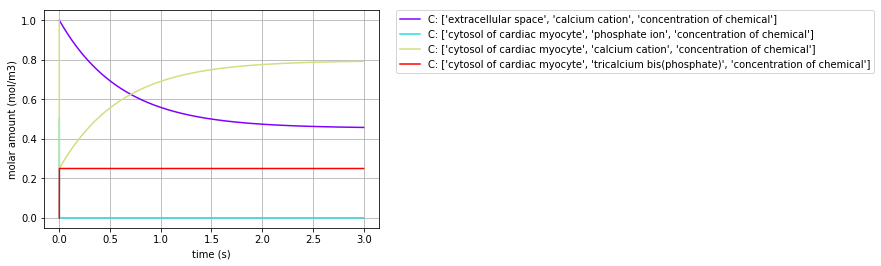

In [97]:
color=plt.cm.rainbow(np.linspace(0,1,len(model.state_vars)))

for i,c in zip(range(len(model.state_vars)),color): 
    plt.plot(t,x[:,i],c=c, label=list(model.state_vars.values())[i][0])
       
plt.xlabel("time (s)")
plt.ylabel("molar amount (mol/m3)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad= 0.)
plt.grid()
